## Read Covid19 Radiography Dataset from Kaggle


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 767M/778M [00:04<00:00, 145MB/s]
100% 778M/778M [00:04<00:00, 166MB/s]


In [ ]:
!unzip '/content/covid19-radiography-database.zip'

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

## Import Library

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
!rm '/content/COVID-19_Radiography_Dataset/COVID.metadata.xlsx'
!rm '/content/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'
!rm '/content/COVID-19_Radiography_Dataset/Normal.metadata.xlsx'
!rm '/content/COVID-19_Radiography_Dataset/README.md.txt'
!rm '/content/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

%cd '/content/COVID-19_Radiography_Dataset'
!rm -rf 'Lung_Opacity'

dir = os.listdir()
for i in range(0, len(dir)):
  os.chdir(dir[i])
  !rm -rf 'masks'
  !mv -v images/*.png .
  !rm -rf 'images'
  os.chdir("..")

base_dir = '/content/COVID-19_Radiography_Dataset'

Streaming output truncated to the last 5000 lines.
renamed 'images/Normal-5500.png' -> './Normal-5500.png'
renamed 'images/Normal-5501.png' -> './Normal-5501.png'
renamed 'images/Normal-5502.png' -> './Normal-5502.png'
renamed 'images/Normal-5503.png' -> './Normal-5503.png'
renamed 'images/Normal-5504.png' -> './Normal-5504.png'
renamed 'images/Normal-5505.png' -> './Normal-5505.png'
renamed 'images/Normal-5506.png' -> './Normal-5506.png'
renamed 'images/Normal-5507.png' -> './Normal-5507.png'
renamed 'images/Normal-5508.png' -> './Normal-5508.png'
renamed 'images/Normal-5509.png' -> './Normal-5509.png'
renamed 'images/Normal-550.png' -> './Normal-550.png'
renamed 'images/Normal-5510.png' -> './Normal-5510.png'
renamed 'images/Normal-5511.png' -> './Normal-5511.png'
renamed 'images/Normal-5512.png' -> './Normal-5512.png'
renamed 'images/Normal-5513.png' -> './Normal-5513.png'
renamed 'images/Normal-5514.png' -> './Normal-5514.png'
renamed 'images/Normal-5515.png' -> './Normal-5515.png'

In [ ]:
# Load dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/COVID 19 Radiography Dataset'

Mounted at /content/drive


## Preprocessing


In [ ]:
def clahe(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  cl1 = clahe.apply(img.astype(np.uint8))
  cl1 = cv2.cvtColor(cl1, cv2.COLOR_GRAY2RGB)
  
  return cl1

In [ ]:
train_datagen = ImageDataGenerator(
                    zoom_range=0.2,
                    rotation_range = 10,
                    fill_mode = 'nearest',
                    preprocessing_function = clahe,
                    validation_split=0.2)
validation_datagen = ImageDataGenerator(
                    validation_split=0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(160, 160),  # change image to 160x160 pixel
        batch_size=24, # every epoch, the model will learn: (number of image)/batch_size 
        class_mode='categorical',
        subset='training')

validation_generator = validation_datagen.flow_from_directory(
        base_dir,
        target_size=(160, 160), 
        batch_size=24,
        class_mode='categorical',
        subset='validation')

train_generator.class_indices

Found 12123 images belonging to 3 classes.
Found 3030 images belonging to 3 classes.


{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}

## Define Model by Using Transfer Learning

###MobileNetV2

In [ ]:
MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape=(160,160,3), include_top=False, weights='imagenet')
MobileNetV2.trainable = True

# Set untrainable layers (layer 1-60 from 154)
for layer in MobileNetV2.layers[:60]:
  layer.trainable = False

inputs = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = MobileNetV2(x, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Optimize model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
epoch = 20
es = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=8)
history = model.fit(
      train_generator,
      epochs=epoch,
      validation_data=validation_generator,
      callbacks=es)
model.save('MobileNetV2_DIP.h5')

Epoch 1/20
506/506 [==============================] - 113s 217ms/step - loss: 0.2552 - accuracy: 0.9066 - val_loss: 0.2145 - val_accuracy: 0.9317
Epoch 2/20
506/506 [==============================] - 106s 210ms/step - loss: 0.1517 - accuracy: 0.9478 - val_loss: 0.2472 - val_accuracy: 0.9178
Epoch 3/20
506/506 [==============================] - 108s 213ms/step - loss: 0.1220 - accuracy: 0.9591 - val_loss: 0.2161 - val_accuracy: 0.9363
Epoch 4/20
506/506 [==============================] - 106s 210ms/step - loss: 0.1096 - accuracy: 0.9611 - val_loss: 0.2194 - val_accuracy: 0.9211
Epoch 5/20
506/506 [==============================] - 106s 210ms/step - loss: 0.0960 - accuracy: 0.9663 - val_loss: 0.1524 - val_accuracy: 0.9528
Epoch 6/20
506/506 [==============================] - 108s 213ms/step - loss: 0.0903 - accuracy: 0.9667 - val_loss: 0.1737 - val_accuracy: 0.9439
Epoch 7/20
506/506 [==============================] - 106s 210ms/step - loss: 0.0829 - accuracy: 0.9700 - val_loss: 0.1890 -

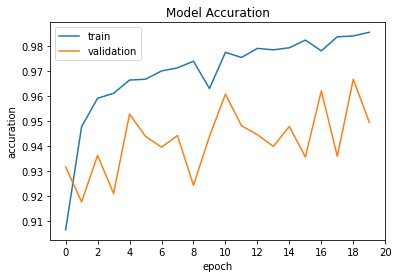

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xticks(np.arange(0, epoch+1, 2))
plt.title("Model Accuration")
plt.xlabel('epoch')
plt.ylabel('accuration')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

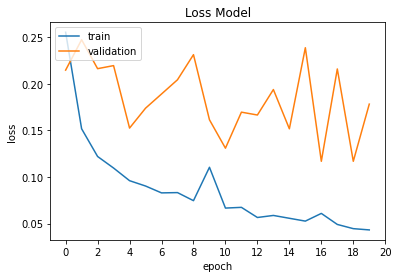

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(np.arange(0, epoch+1, 2))
plt.title("Loss Model")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### MobileNetV2 Model Evaluation

In [ ]:
# Predict image class label using generator for evaluation
test_generator = validation_datagen.flow_from_directory(
        base_dir,
        target_size=(160, 160),
        batch_size=24,
        class_mode='categorical',
        subset='validation',
        shuffle=False)

print(test_generator.class_indices)

model.trainable = False
y_test = test_generator.classes
pred = model.predict(test_generator)
y_pred = np.array([np.argmax(x) for x in pred])

Found 3030 images belonging to 3 classes.
{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}


              precision    recall  f1-score   support

           0       0.96      0.74      0.84       723
           1       0.91      0.96      0.94      2038
           2       0.77      0.96      0.86       269

    accuracy                           0.91      3030
   macro avg       0.88      0.89      0.88      3030
weighted avg       0.91      0.91      0.90      3030
 

[[ 534  176   13]
 [  20 1955   63]
 [   0   11  258]] 



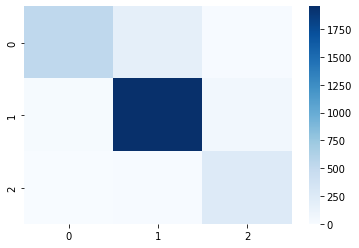

In [ ]:
cr = classification_report(y_test, y_pred) 
cm = confusion_matrix(y_test, y_pred)
print(cr, '\n')
print(cm, '\n')

sns.heatmap(cm, cmap='Blues')
plt.show()

### Resnet50

In [ ]:
Resnet50 = tf.keras.applications.resnet50.ResNet50(input_shape=(160,160,3), include_top=False, weights='imagenet')

Resnet50.trainable = True

# Set untrainable layers (layer 1-80 from 175 layers)
for layer in Resnet50.layers[:80]:
  layer.trainable = False

inputs = tf.keras.Input(shape=(160, 160, 3))
x = Resnet50(inputs, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(3,activation='softmax')(x)

model2 = tf.keras.Model(inputs, outputs)

# Optimize model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt
                ,loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

model2.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 22,090,755
Non-tr

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=8)
history2 = model2.fit(
      train_generator,
      epochs=epoch,
      validation_data=validation_generator,
      callbacks=es)
model2.save('ResNet50_DIP.h5')

Epoch 1/20
506/506 [==============================] - 125s 236ms/step - loss: 0.3069 - accuracy: 0.8936 - val_loss: 0.1782 - val_accuracy: 0.9360
Epoch 2/20
506/506 [==============================] - 116s 229ms/step - loss: 0.1546 - accuracy: 0.9445 - val_loss: 0.1735 - val_accuracy: 0.9396
Epoch 3/20
506/506 [==============================] - 117s 230ms/step - loss: 0.1346 - accuracy: 0.9524 - val_loss: 0.1667 - val_accuracy: 0.9475
Epoch 4/20
506/506 [==============================] - 117s 230ms/step - loss: 0.1117 - accuracy: 0.9587 - val_loss: 0.1868 - val_accuracy: 0.9360
Epoch 5/20
506/506 [==============================] - 117s 231ms/step - loss: 0.1010 - accuracy: 0.9653 - val_loss: 0.1543 - val_accuracy: 0.9495
Epoch 6/20
506/506 [==============================] - 116s 229ms/step - loss: 0.0928 - accuracy: 0.9687 - val_loss: 0.1348 - val_accuracy: 0.9571
Epoch 7/20
506/506 [==============================] - 116s 230ms/step - loss: 0.0874 - accuracy: 0.9677 - val_loss: 0.1382 -

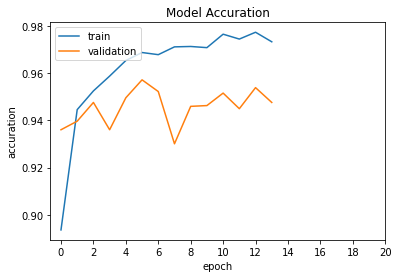

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.xticks(np.arange(0, epoch+1, 2))
plt.title("Model Accuration")
plt.xlabel('epoch')
plt.ylabel('accuration')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

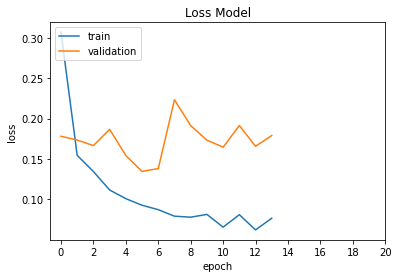

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xticks(np.arange(0, epoch+1, 2))
plt.title("Loss Model")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### ResNet50 Model Evaluation

In [ ]:
# Predict using generator
print(test_generator.class_indices)

model2.trainable = False
y_test2 = test_generator.classes
pred = model2.predict(test_generator)
y_pred2 = np.array([np.argmax(x) for x in pred])

{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}


              precision    recall  f1-score   support

           0       0.99      0.80      0.89       723
           1       0.92      0.99      0.95      2038
           2       0.97      0.85      0.90       269

    accuracy                           0.94      3030
   macro avg       0.96      0.88      0.92      3030
weighted avg       0.94      0.94      0.93      3030
 

[[ 581  142    0]
 [   4 2027    7]
 [   1   40  228]] 



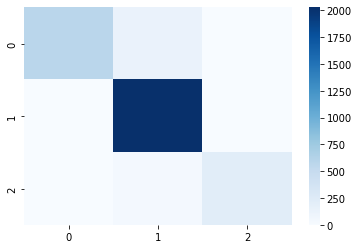

In [ ]:
cr2 = classification_report(y_test2, y_pred2) 
cm2 = confusion_matrix(y_test2, y_pred2)
print(cr2, '\n')
print(cm2, '\n')

sns.heatmap(cm2, cmap='Blues')
plt.show()